In [3]:
from keras import applications,optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model 

from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, warnings
from keras.layers import Dropout, Flatten, Dense

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D

from keras_squeezenet import SqueezeNet
from glob import glob

Using TensorFlow backend.


In [4]:
import shutil,os
import pandas as pd
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# with open('sim-data-capture/sim_data_large.yaml', 'r') as f:
#     df = pd.io.json.json_normalize(yaml.load(f))

# def parse_values(val):

#     if len(val) == 0:
#         return 'noColor'
#     else:
#         return (val[0]['class'])
    
# df['color'] = df.annotations.map(parse_values)
# df.filename = df.filename.str.replace('sim_data_capture/','sim-data-capture/',)

In [4]:
shutil.rmtree('data/train/')
shutil.rmtree('data/valid/')
os.mkdir('data/train/')
os.mkdir('data/valid/')

os.mkdir('data/train/Green')
os.mkdir('data/train/Red')
os.mkdir('data/train/Yellow')
os.mkdir('data/train/noColor')

os.mkdir('data/valid/Green')
os.mkdir('data/valid/Red')
os.mkdir('data/valid/Yellow')
os.mkdir('data/valid/noColor')

for color in ['Green','Yellow','Red','noColor']:
    
    #files = df[df.color == color].filename.values.tolist()
    files = glob('BiggerTrainingData/'+color+'/*.jpeg')
#     if color == 'Red':
#         np.random.shuffle(files)
#         files = files[:55] #randomly select only 55 enteries
    print(color, len(files))
    for filename in files:
        if np.random.rand(1)[0] < 0.8:
            shutil.copy(src= filename, dst='data/train/'+color+'/')
        else:    
            shutil.copy(src= filename, dst='data/valid/'+color+'/')


Green 1039
Yellow 964
Red 998
noColor 1089


In [9]:
img_width, img_height = 227, 227
# train_data_dir = "data/train"
# validation_data_dir = "data/valid"
train_data_dir = "data/full-image/original-dataset/train"
validation_data_dir = "data/full-image/original-dataset/valid"
nb_train_samples = 2080
nb_validation_samples = 480 
batch_size = 16
epochs = 100

In [10]:
#training data generator
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)

In [11]:
#validation data generator
valid_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)


In [12]:
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

Found 162 images belonging to 4 classes.


In [13]:

validation_generator = valid_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
#batch_size = batch_size*0.40, 

class_mode = "categorical")

Found 34 images belonging to 4 classes.


In [31]:
classes = 4

model = SqueezeNet(include_top=False, pooling=None , input_shape=(227,227,3))
for layer in model.layers:
    #print(layer.trainable, end=',')
    layer.trainable = False

x = model.output
#reducing the size through convolutions so parameters stay reasonable
x = Dropout(0.5, name='drop9')(x)
x = Convolution2D(250, kernel_size=(3, 3), strides=(2,2), padding='valid', name='conv10')(x)
x = Activation('relu', name='relu_conv10')(x)

x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.6)(x)
x = Dense(512, activation="relu")(x)
x = Dense(classes, activation="softmax")(x)



model_final = Model(inputs = model.input, outputs = x)
#optimizers.SGD(lr=0.00005) also gives decent results
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"])


In [32]:
#model_final.summary()

In [33]:
model_final.fit_generator(
train_generator,
steps_per_epoch = 200,# nb_train_samples/batch_size,
epochs = 200,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size)

Epoch 1/200
200/200 [==============================] - 12s - loss: 2.4180 - acc: 0.2622 - val_loss: 1.3814 - val_acc: 0.2158
Epoch 2/200
200/200 [==============================] - 12s - loss: 1.4157 - acc: 0.3275 - val_loss: 1.2529 - val_acc: 0.5139
Epoch 3/200
200/200 [==============================] - 12s - loss: 1.2381 - acc: 0.4231 - val_loss: 1.0146 - val_acc: 0.4818
Epoch 4/200
200/200 [==============================] - 12s - loss: 1.1273 - acc: 0.4634 - val_loss: 1.0219 - val_acc: 0.5182
Epoch 5/200
200/200 [==============================] - 12s - loss: 1.0491 - acc: 0.5050 - val_loss: 1.0029 - val_acc: 0.5876
Epoch 6/200
200/200 [==============================] - 12s - loss: 0.9974 - acc: 0.5169 - val_loss: 0.9112 - val_acc: 0.5951
Epoch 7/200
200/200 [==============================] - 12s - loss: 0.9648 - acc: 0.5244 - val_loss: 0.8998 - val_acc: 0.5962
Epoch 8/200
200/200 [==============================] - 12s - loss: 0.9337 - acc: 0.5475 - val_loss: 0.8202 - val_acc: 0.6143


200/200 [==============================] - 12s - loss: 0.1024 - acc: 0.9622 - val_loss: 0.0902 - val_acc: 0.9715
Epoch 67/200
200/200 [==============================] - 12s - loss: 0.0934 - acc: 0.9647 - val_loss: 0.1221 - val_acc: 0.9594
Epoch 68/200
200/200 [==============================] - 12s - loss: 0.0904 - acc: 0.9666 - val_loss: 0.1000 - val_acc: 0.9682
Epoch 69/200
200/200 [==============================] - 12s - loss: 0.1029 - acc: 0.9631 - val_loss: 0.0906 - val_acc: 0.9712
Epoch 70/200
200/200 [==============================] - 12s - loss: 0.0853 - acc: 0.9669 - val_loss: 0.0945 - val_acc: 0.9704
Epoch 71/200
200/200 [==============================] - 12s - loss: 0.0907 - acc: 0.9650 - val_loss: 0.0903 - val_acc: 0.9733
Epoch 72/200
200/200 [==============================] - 12s - loss: 0.0845 - acc: 0.9672 - val_loss: 0.0999 - val_acc: 0.9647
Epoch 73/200
200/200 [==============================] - 12s - loss: 0.0858 - acc: 0.9650 - val_loss: 0.1250 - val_acc: 0.9573
Epoch

200/200 [==============================] - 12s - loss: 0.0331 - acc: 0.9869 - val_loss: 0.1377 - val_acc: 0.9765
Epoch 195/200
200/200 [==============================] - 12s - loss: 0.0329 - acc: 0.9881 - val_loss: 0.0806 - val_acc: 0.9818
Epoch 196/200
200/200 [==============================] - 14s - loss: 0.0337 - acc: 0.9872 - val_loss: 0.1018 - val_acc: 0.9765
Epoch 197/200
200/200 [==============================] - 14s - loss: 0.0362 - acc: 0.9872 - val_loss: 0.0938 - val_acc: 0.9818
Epoch 198/200
200/200 [==============================] - 20s - loss: 0.0274 - acc: 0.9912 - val_loss: 0.1224 - val_acc: 0.9797
Epoch 199/200
200/200 [==============================] - 18s - loss: 0.0362 - acc: 0.9881 - val_loss: 0.1359 - val_acc: 0.9690
Epoch 200/200
200/200 [==============================] - 18s - loss: 0.0393 - acc: 0.9853 - val_loss: 0.0931 - val_acc: 0.9744


### Saved the model

In [34]:

models_folder_path = ''
model_name = 'squeezenet_transfer_learned'

arch_path = models_folder_path + model_name + "_architecture.json"
weights_path = models_folder_path + model_name + "_weights.h5"

# serialize model to JSON
model_json = model_final.to_json()
with open(arch_path, "w") as json_file:
    json_file.write(model_json)
print('Model architecture saved: ' + arch_path)
    
# serialize weights to HDF5
model_final.save_weights(weights_path)
print('Weights saved: ' + weights_path)

model.save('model_checkpoint.h5')
print('Model checkpoint saved: model_checkpoint.h5')

Model architecture saved: squeezenet_transfer_learned_architecture.json
Weights saved: squeezenet_transfer_learned_weights.h5
Model checkpoint saved: model_checkpoint.h5


### Load the model

In [16]:

# models_folder_path = ''
# model_name = 'squeezenet_transfer_learned'

# arch_path = models_folder_path + model_name + "_architecture.json"
# weights_path = models_folder_path + model_name + "_weights.h5"

# pull the ROS node folder
models_folder_path = '../../ros/src/tl_detector/keras_model/'
model_name = 'squeezenet_transfer_learned'

arch_path = models_folder_path + model_name + "_architecture.json"
weights_path = models_folder_path + model_name + "_weights.h5"

In [17]:
from keras.models import model_from_json

# load architecture
json_file = open(arch_path)
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights
loaded_model.load_weights(weights_path)

print("Model loaded")

Model loaded


### Check loaded model

In [18]:

validation_generator = valid_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

images, labels = next(validation_generator)
print('Validation samples: {}'.format(len(labels)))

Found 34 images belonging to 4 classes.
Validation samples: 32


## Double check the model accuracy with validation samples (simulator)

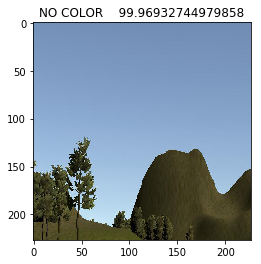

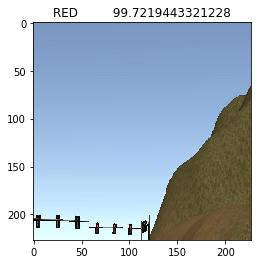

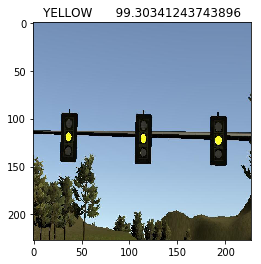

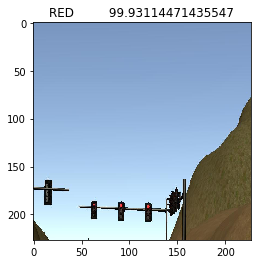

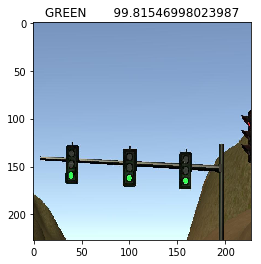

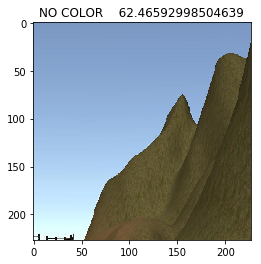

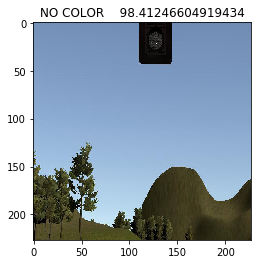

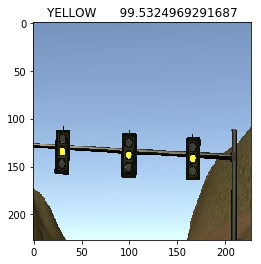

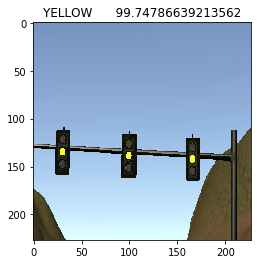

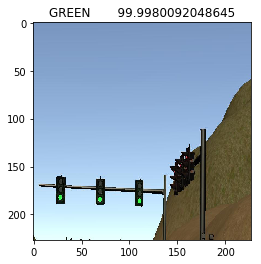

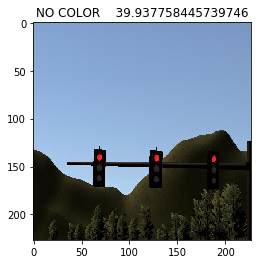

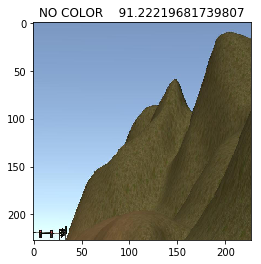

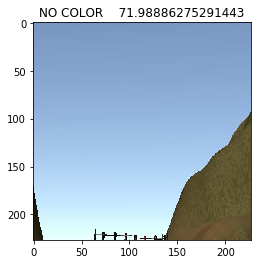

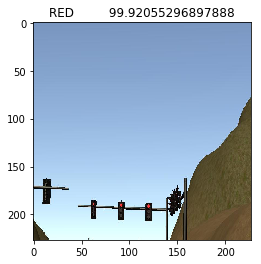

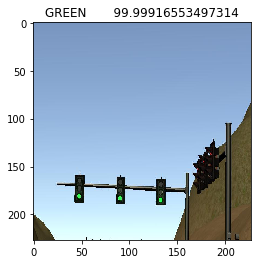

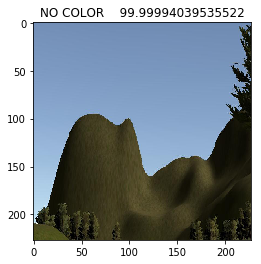

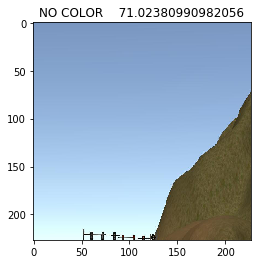

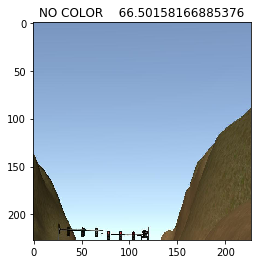

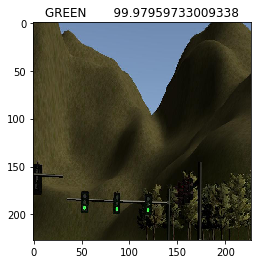

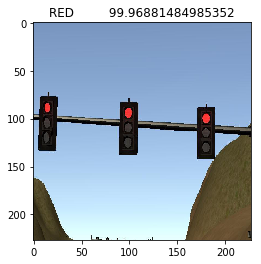

In [19]:

traffic_light_states = ['GREEN', 'RED', 'YELLOW', 'NO COLOR']

for i in range(len(images[:20])):
    
    img = images[i]
    
    plt.figure()
    
    prediction = loaded_model.predict(np.array([img]))[0]
    #print(prediction)
    prediction_label = traffic_light_states[prediction.argmax()]
    
    plt.title('{0:10}  {1}'.format(prediction_label, prediction.max()*100.0) )
    plt.imshow(img)


## Double check the model accuracy with validation samples (real)

In [21]:
real_img_data_dir = "data/annotated/dataset-sdcnd-capstone/data/real_training_data"

real_img_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)

real_img_generator = real_img_datagen.flow_from_directory(
real_img_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 704 images belonging to 4 classes.


Real samples: 32


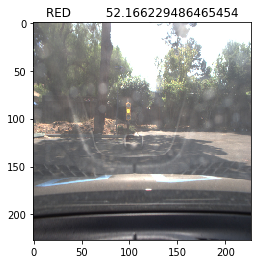

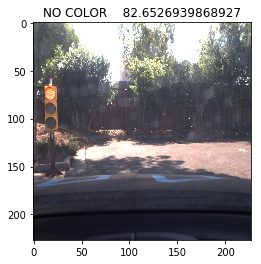

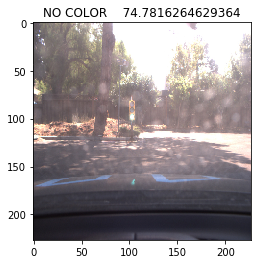

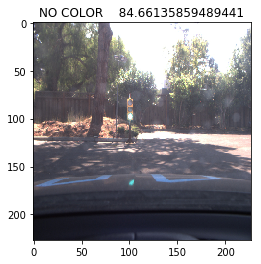

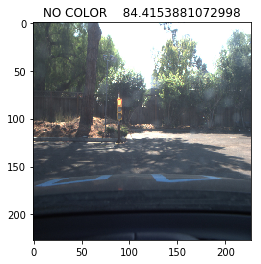

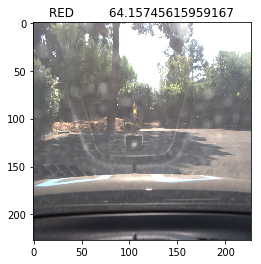

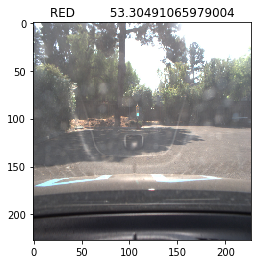

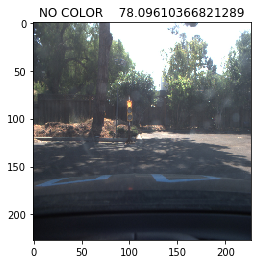

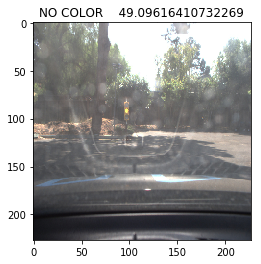

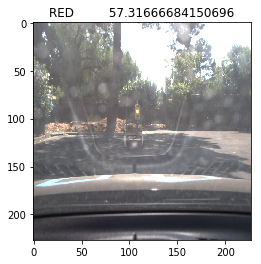

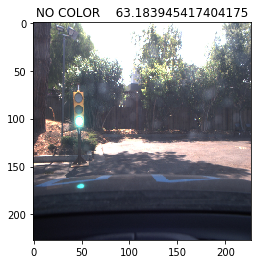

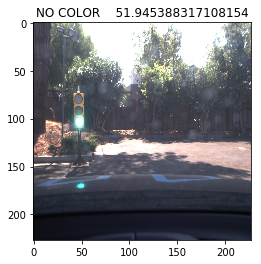

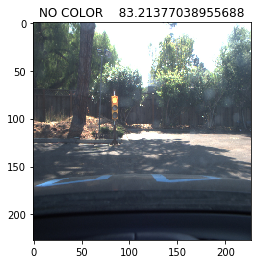

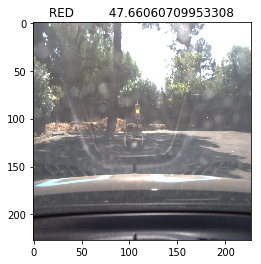

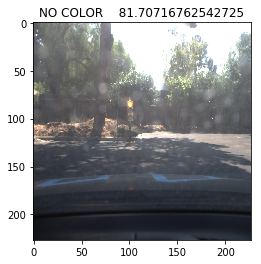

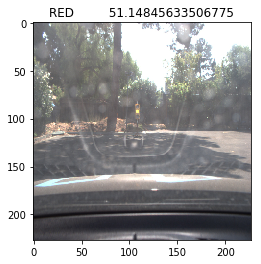

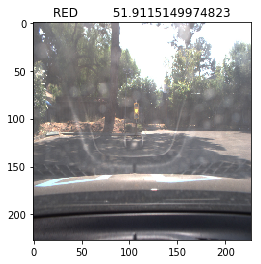

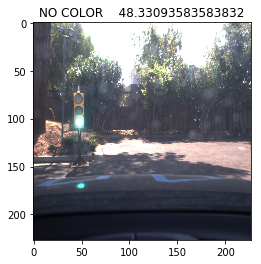

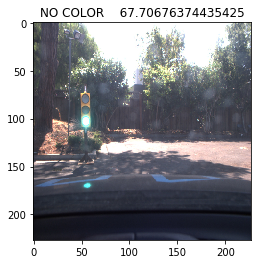

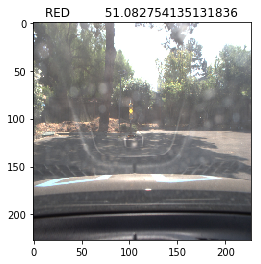

In [22]:
traffic_light_states = ['GREEN', 'RED', 'YELLOW', 'NO COLOR']

real_images, real_labels = next(real_img_generator)

print('Real samples: {}'.format(len(real_labels)))

for i in range(len(real_images[:20])):
    
    img = real_images[i]
    
    plt.figure()
    
    prediction = loaded_model.predict(np.array([img]))[0]
    prediction_label = traffic_light_states[prediction.argmax()]
    
    plt.title('{0:10}  {1}'.format(prediction_label, prediction.max()*100.0) )
    plt.imshow(img)
